In [11]:
import networkx as nx
import matplotlib.pyplot as plt

triplets = [
    ("A", "likes", "B"),
    ("B", "likes", "C"),
    ("A", "likes", "C"),
    ("D", "likes", "E"),
    ("E", "likes", "F"),
    ("F", "likes", "G"),
    ("G", "likes", "H"),
]
# Create a knowledge graph
G = nx.DiGraph()
for triplet in triplets:
    G.add_edge(triplet[0], triplet[2], label=triplet[1])

In [19]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.messages import HumanMessage
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
file_path = input("Enter the path to the PDF file: ")
if file_path == '':
    file_path = 'https://arxiv.org/pdf/1706.03762'
# create a vector store
loader = PyPDFLoader(file_path, extract_images=True)
pages = loader.load_and_split()
faiss_index = FAISS.from_documents(pages, OpenAIEmbeddings())
retriever = faiss_index.as_retriever(search_type="similarity", search_kwargs={"k": 10})
llm = ChatOpenAI(model="gpt-4o-mini")


# create a prompt for the contextualize_q_prompt that incorporates a chat history
contextualize_q_system_prompt = """Given a chat history and the latest user question \
which might reference context in the chat history, formulate a standalone question \
which can be understood without the chat history. Do NOT answer the question, \
just reformulate it if needed and otherwise return it as is."""
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder(
            "chat_history"
        ),  # this placeholder will store a list of previous messages
        ("human", "{input}"),
    ]
)

# create a retriver that is history aware
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

# qa system prompt
triplet_extraction_prompt = """

    You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question.
    If you don't know the answer, say "The answer is not in the context."
    If you have to answer a question that involves latex code, output it in a plain text format.
    The answer to the questions must be in the form of a list of knowledge graph triplets.
    A triplet is a triple of the form (subject, predicate, object).
    The subject, predicate, and object must all be nodes in the knowledge graph so they must not be too long.
    The predicate must be a relation between the subject and object.
    Answer only with the one and only one list of triplets.
    Format your response as a Python list of tuples, like this:
    [("Subject1", "Predicate1", "Object1"), ("Subject2", "Predicate2", "Object2")]
    Do not include any other text or explanations in your response.
    {context}

"""


# qa final prompt
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", triplet_extraction_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

# final chain
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

user_input = input("You: ")
chat_history = []
if user_input.lower() == "exit":
    print("Chatbot: Goodbye!")
else:
    ai_msg = rag_chain.invoke({"input": user_input, "chat_history": chat_history})
    chat_history.extend([HumanMessage(content=user_input), ai_msg["answer"]])
print("Chatbot: ", end="", flush=True)
print(ai_msg["answer"])


Chatbot: [("Encoder", "maps", "input sequence of symbol representations"), ("Encoder", "generates", "continuous representations z"), ("Continuous representations z", "used by", "decoder")]


In [26]:
import ast
triplets = ast.literal_eval(ai_msg["answer"])
triplets

[('Encoder', 'maps', 'input sequence of symbol representations'),
 ('Encoder', 'generates', 'continuous representations z'),
 ('Continuous representations z', 'used by', 'decoder')]

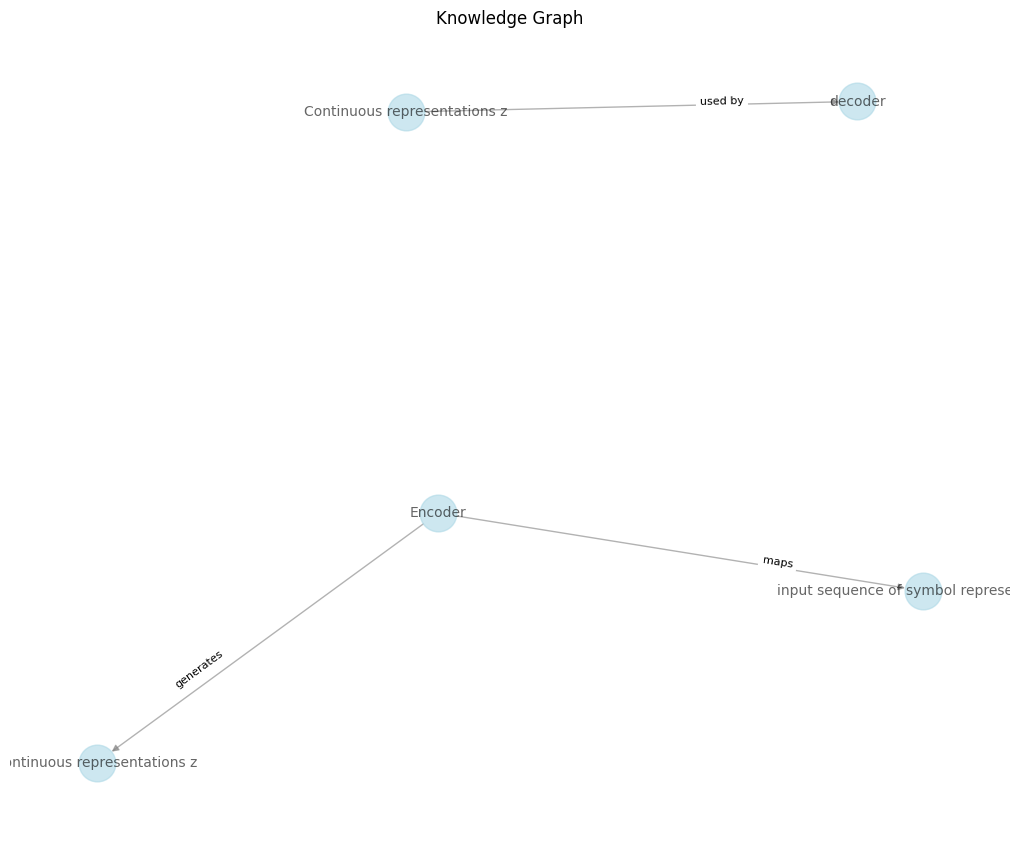

In [27]:
G = nx.DiGraph()
for triplet in triplets:
    G.add_edge(triplet[0], triplet[2], label=triplet[1])
pos = nx.spring_layout(G, seed=42, k=1.1)
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color='lightblue', edge_color='gray', alpha=0.6)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('Knowledge Graph')
plt.show()